In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances


# 1. Data Preparation and Preprocessing

In [ ]:

# Load your traffic data (replace with your own dataset)
traffic_df = pd.read_csv('traffic4cast.csv')  # Assuming the file is present
# For simplicity, assume 'Junction' is the intersection identifier and 'Vehicles' is traffic flow

# Example of preprocessing: normalize 'Vehicles' column
traffic_data = traffic_df[['Junction', 'Vehicles']]  # Selecting relevant columns
scaler = StandardScaler()
traffic_data['Vehicles'] = scaler.fit_transform(traffic_data[['Vehicles']])  # Normalize traffic flow data

<ipython-input-7-acdbc136186d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_data['Vehicles'] = scaler.fit_transform(traffic_data[['Vehicles']])  # Normalize traffic flow data


# ================================
# 2. Sparse Graph Construction (Using Proximity)

In [ ]:
# Use a subset of nodes for testing if memory is a problem
subset_size = 100  # Adjust the subset size to avoid memory issues
traffic_data_subset = traffic_data.head(subset_size)

# Example: Construct edges based on proximity (e.g., within a certain Euclidean distance)
# You can replace this with road network-based edge construction
coords = np.array(traffic_data_subset['Junction'])  # Assume the Junction values represent coordinates (for demo)

# Compute pairwise Euclidean distances between nodes
distances = euclidean_distances(coords.reshape(-1, 1))  # Reshape if needed based on your data format
threshold_distance = 10  # Only connect nodes that are close to each other
edge_index = np.array(np.where(distances < threshold_distance))  # Indices of nodes to connect
edge_index = torch.tensor(edge_index, dtype=torch.long)

# Create node features (traffic flow at each intersection)
x = torch.tensor(traffic_data_subset['Vehicles'].values, dtype=torch.float).view(-1, 1)  # Node features matrix (1D feature)

# Create the graph data object for PyTorch Geometric
data = Data(x=x, edge_index=edge_index)

# 3. GNN Model Definition

In [ ]:
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)  # First GCN layer
        self.conv2 = GCNConv(hidden_dim, output_dim)  # Second GCN layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))  # Apply GCN layer 1
        x = self.conv2(x, edge_index)  # Apply GCN layer 2
        return x  # Output traffic flow predictions


# 4. Training Setup

In [ ]:
# Initialize the GNN model
input_dim = 1  # We have one feature: traffic flow
hidden_dim = 16  # Hidden layer size (can be adjusted)
output_dim = 1  # Output dimension (predicted traffic flow)
model = GNNModel(input_dim, hidden_dim, output_dim)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer

# 5. Training Loop

In [ ]:
# Set number of epochs for training
num_epochs = 100

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear the gradients

    # Forward pass through the GNN model
    output = model(data)  # Get predicted traffic flow at each intersection

    # Compute the loss
    loss = criterion(output.squeeze(), data.x.squeeze())  # Compare predicted vs. actual traffic flow

    # Backward pass: calculate gradients and update weights
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:  # Print every 10 epochs
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 1/100, Loss: 0.1338
Epoch 11/100, Loss: 0.1278
Epoch 21/100, Loss: 0.1278
Epoch 31/100, Loss: 0.1278
Epoch 41/100, Loss: 0.1278
Epoch 51/100, Loss: 0.1278
Epoch 61/100, Loss: 0.1278
Epoch 71/100, Loss: 0.1278
Epoch 81/100, Loss: 0.1278
Epoch 91/100, Loss: 0.1278


# 6. Evaluation

In [ ]:
# After training, evaluate the model
model.eval()  # Set the model to evaluation mode

# Make predictions
with torch.no_grad():
    predicted_traffic_flow = model(data).squeeze().numpy()  # Get predicted traffic flow

# Denormalize the predicted traffic flow
predicted_traffic_flow = scaler.inverse_transform(predicted_traffic_flow.reshape(-1, 1))

# Display predicted traffic flow at each intersection
print("\nPredicted Traffic Flow at Intersections:")
for idx, flow in enumerate(predicted_traffic_flow):
    print(f"Intersection {traffic_data_subset.iloc[idx]['Junction']}: {flow[0]:.2f} vehicles")


Predicted Traffic Flow at Intersections:
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
Intersection 1.0: 19.84 vehicles
I

In [ ]:
# Print out the columns in combined_df
print("Columns in combined_df:", combined_df.columns)

Columns in combined_df: Index(['DateTime', 'Junction', 'Vehicles', 'ID'], dtype='object')


Columns in combined_df: ['DateTime', 'Junction', 'Vehicles', 'ID']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  48120 non-null  object 
 1   Junction  48120 non-null  float32
 2   Vehicles  48120 non-null  float32
 3   ID        48120 non-null  float64
dtypes: float32(2), float64(1), object(1)
memory usage: 4.2 MB
None


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 47900899333817.06
Epoch 2, Loss: 1737592.146775266
Epoch 3, Loss: 2276123.568317819
Epoch 4, Loss: 1483725140338.7266
Epoch 5, Loss: 1425399437432.1462
Epoch 6, Loss: 1754801377756.627
Epoch 7, Loss: 1378306656066.4392
Epoch 8, Loss: 1112899544762.8274
Epoch 9, Loss: 1103745831074.2617
Epoch 10, Loss: 537389783484.2049


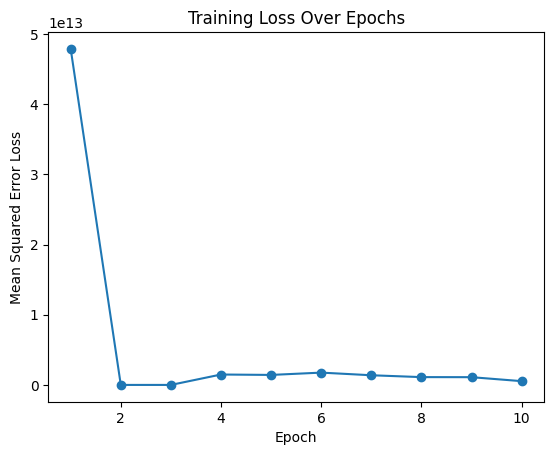

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load and reduce dataset in chunks if large
chunk_size = 10000  # Adjust chunk size based on memory capacity
data_chunks = []

for chunk in pd.read_csv('traffic4cast.csv', chunksize=chunk_size):
    # Downcast numerical columns to save memory
    for col in chunk.select_dtypes(include=['float', 'int']).columns:
        chunk[col] = pd.to_numeric(chunk[col], downcast='float')
    data_chunks.append(chunk)

combined_df = pd.concat(data_chunks)

# Display columns and types to confirm memory optimization
print("Columns in combined_df:", list(combined_df.columns))
print(combined_df.info(memory_usage='deep'))

# Convert DateTime column to timestamp in smaller chunks
combined_df['DateTime'] = pd.to_datetime(combined_df['DateTime'], errors='coerce')
combined_df['DateTime'] = combined_df['DateTime'].map(pd.Timestamp.timestamp)

# Encode categorical columns as needed with label encoding instead of one-hot
from sklearn.preprocessing import LabelEncoder

for col in ['Junction', 'ID']:  # Add more columns if needed
    combined_df[col] = LabelEncoder().fit_transform(combined_df[col])

# Set the target column 'Vehicles' and prepare features and target
X = torch.tensor(combined_df.drop('Vehicles', axis=1).values, dtype=torch.float32)
y = torch.tensor(combined_df['Vehicles'].values, dtype=torch.float32)

# Create dataset and data loader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define the neural network model
class TrafficPredictionModel(nn.Module):
    def __init__(self):
        super(TrafficPredictionModel, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = TrafficPredictionModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Track the loss for each epoch
epoch_losses = []

# Training loop
for epoch in range(10):
    epoch_loss = 0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Compute average loss for the epoch and store it
    avg_epoch_loss = epoch_loss / len(dataloader)
    epoch_losses.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_epoch_loss}')

# Plotting the loss over epochs
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [ ]:
# Print graph information manually
print("Graph information:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print("Nodes:", G.nodes())
print("Edges with attributes:")
for u, v, attr in G.edges(data=True):
    print(f"({u}, {v}) with attributes {attr}")

Graph information:
Number of nodes: 4
Number of edges: 6
Nodes: [1, 2, 3, 4]
Edges with attributes:
(1, 2) with attributes {'traffic_speed': 40, 'travel_time': 10, 'traffic_volume': 200}
(1, 3) with attributes {'traffic_speed': 35, 'travel_time': 12, 'traffic_volume': 180}
(2, 3) with attributes {'traffic_speed': 50, 'travel_time': 8, 'traffic_volume': 220}
(2, 4) with attributes {'traffic_speed': 45, 'travel_time': 9, 'traffic_volume': 210}
(3, 4) with attributes {'traffic_speed': 30, 'travel_time': 11, 'traffic_volume': 190}
(4, 1) with attributes {'traffic_speed': 55, 'travel_time': 7, 'traffic_volume': 230}


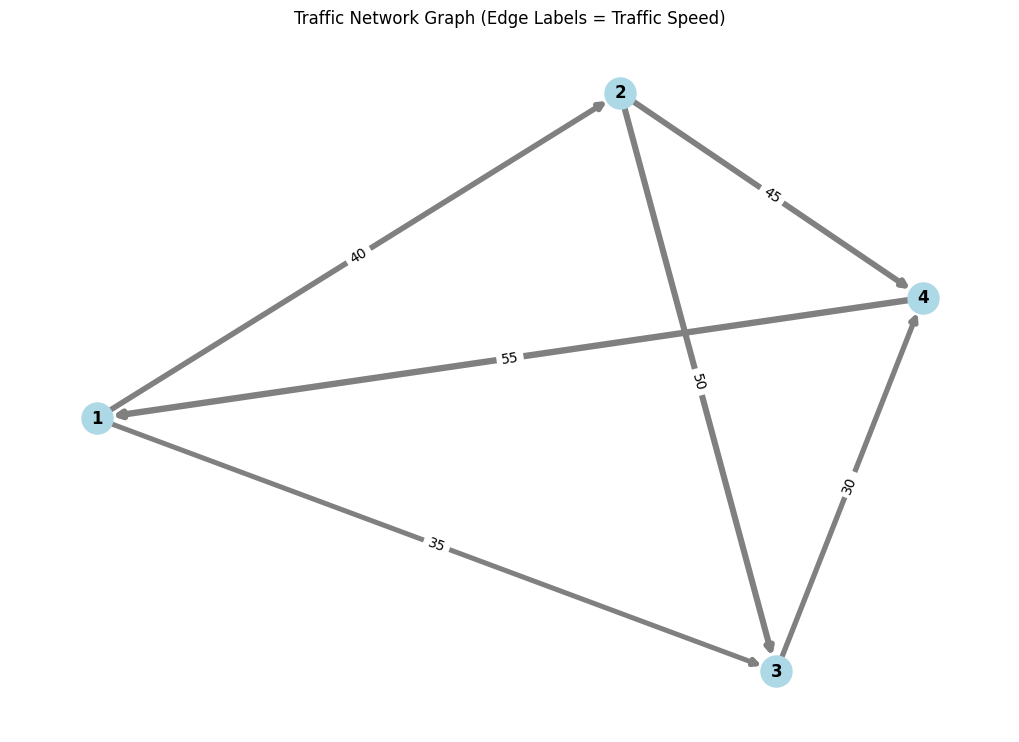

In [ ]:
import matplotlib.pyplot as plt

# Draw the graph with traffic volume as edge width
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G)  # Positions for all nodes
edge_width = [d['traffic_volume'] / 50 for (u, v, d) in G.edges(data=True)]

nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue",
        font_weight="bold", width=edge_width, edge_color="gray")
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['traffic_speed'] for u, v, d in G.edges(data=True)})

plt.title("Traffic Network Graph (Edge Labels = Traffic Speed)")
plt.show()